Name: Kieran Fitzmaurice

# Electric Potential Near a Capacitor

(Adapted from textbook exercise 9.3)

Consider the following simple model of an electronic capacitor, consisting of two flat metal plates enclosed in a square metal box:

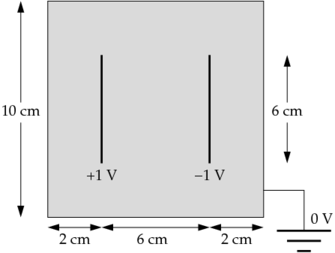

For simplicity let us model the system in two dimensions. Using any of the methods we have studied, write a program to calculate the electrostatic potential in the box on a grid of $101\times101$ points (including the boundaries), where the walls of the box are at voltage zero and the two plates (which are of negligible thickness) are at voltages $\pm1$ V as shown. Have your program calculate the value of the potential at each grid point to a precision of $10^{-6}$ V and then use `imshow` to plot of the result.

> Hint: Notice that the capacitor plates are at fixed *voltage*, not fixed charge. In effect, the capacitor plates are part of the boundary condition in this case: they behave the same way as the walls of the box, with potentials that are fixed at a certain value and cannot change.

Solution converged after 2613 steps.


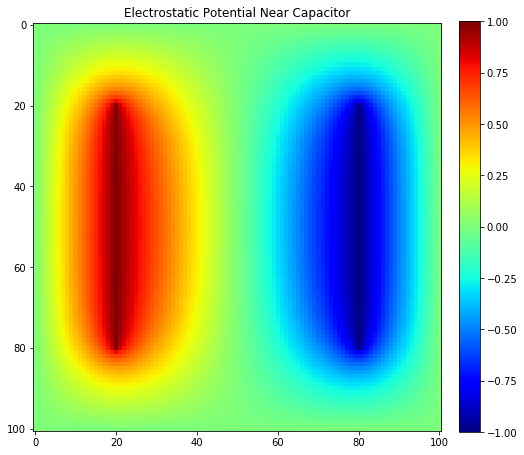

In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

V = np.zeros((101, 101))

#Boundary Conditions:
cap1 = np.ones(61)
cap2 = -1*cap1

V[20:-20,20] = cap1
V[20:-20,80] = cap2


for i in range(10**6):
    V_last = V.copy()
    left = np.roll(V, 1, axis=1)
    right = np.roll(V, -1, axis=1)
    above = np.roll(V, -1, axis=0)
    below = np.roll(V, 1, axis=0)
    V[1:-1, 1:-1] = 0.25*(left[1:-1, 1:-1] + right[1:-1, 1:-1] +
                          above[1:-1, 1:-1] + below[1:-1, 1:-1])
    #Capacitor Voltage Constant
    V[20:-20,20] = cap1
    V[20:-20,80] = cap2
    
    if np.max(abs(V - V_last)) < 1e-6: #Tolerance
        print("Solution converged after", i, "steps.")
        break
else:
    print("Solution failed to converge! (╯°□°）╯︵ ┻━┻")
    
fig = plt.figure(figsize = (8,8))
plt.imshow(V,cmap = "jet")
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Electrostatic Potential Near Capacitor")
plt.show()

# Thermal Diffusion in the Earth's Crust

(Adapted from textbook exercise 9.4)

A classic example of a diffusion problem with a time-varying boundary condition is the diffusion of heat into the crust of the Earth, as surface temperature varies with the seasons. Suppose the mean daily temperature at a particular point on the surface varies as:
$$T_0(t) = A + B\sin \frac{2\pi t}{\tau}\,,$$
where $\tau=365$ days, $A=10^\circ$C and $B=12^\circ$C. At a depth of $20$ m below the surface almost all annual temperature variation is ironed out and the temperature is, to a good approximation, a constant $11^\circ$C (which is higher than the mean surface temperature of $10^\circ$C&mdash;temperature increases with depth, due to heating from the hot core of the planet). The thermal diffusivity of the Earth's crust varies somewhat from place to place, but for our purposes we will treat it as constant with value $D=0.1$ m$^2$/day.

Write a program to calculate the temperature profile of the crust as a function of depth up to 20 m and time up to 10 years. Start with temperature everywhere equal to $10^\circ$C, except at the surface and the deepest point, choose values for the number of grid points and the time-step $h$, then run your program for the first nine simulated years, to allow it to settle down into whatever pattern it reaches. Then for the tenth and final year plot four temperature profiles taken at 3-month intervals on a single graph to illustrate how the temperature changes as a function of depth and time.

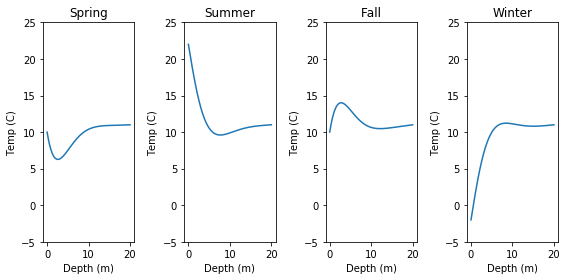

In [2]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt

L = 20
D = 0.1
A = 10
B = 12
tau = 365
N = 200
a = L/N
x = np.linspace(0, L, N+1) #N slices is N+1 grid points

h = 0.01 #time step
tmax = 10*tau
time = np.arange(0, tmax, h)

T = 50*np.ones(N+1) #inital conditions
T0 = A
T20 = 11
T[0], T[-1] = T0, T20
temperature = [] #list to store values

for t in time:
    temperature.append(T.copy())
    T[1:N] += (h*D/a**2)*(T[0:N-1] + T[2:N+1] - 2*T[1:N])
    T0 = A + B*np.sin(2*np.pi*t/tau)
    T[0], T[-1] = T0, T20
    
T1 = temperature[int(9*tau/h)]
T2 = temperature[int(9.25*tau/h)]
T3 = temperature[int(9.5*tau/h)]
T4 = temperature[int(9.75*tau/h)]

fig,ax = plt.subplots(nrows = 1, ncols = 4,figsize = (8,4))
ax1,ax2,ax3,ax4 = ax

ax1.plot(x,T1)
ax1.axis(ymin = -5,ymax = 25)
ax1.set_title("Spring")
ax1.set_xlabel("Depth (m)")
ax1.set_ylabel("Temp (C)")
ax2.plot(x,T2)
ax2.set_title("Summer")
ax2.set_xlabel("Depth (m)")
ax2.set_ylabel("Temp (C)")
ax2.axis(ymin = -5,ymax = 25)
ax3.plot(x,T3)
ax3.set_title("Fall")
ax3.set_xlabel("Depth (m)")
ax3.set_ylabel("Temp (C)")
ax3.axis(ymin = -5,ymax = 25)
ax4.plot(x,T4)
ax4.set_title("Winter")
ax4.set_xlabel("Depth (m)")
ax4.set_ylabel("Temp (C)")
ax4.axis(ymin = -5,ymax = 25)

plt.tight_layout()
plt.show()

# The Schr&ouml;dinger Equation and the Crank-Nicolson Method

(Adapted from textbook exercise 9.8)

Perhaps the most important partial differential equation, at least for physicists, is the Schr&ouml;dinger equation. This exercise uses the Crank-Nicolson method to solve the full time-dependent Schr&ouml;dinger equation and hence develop a picture of how a wavefunction evolves over time.

In one dimension the Schr&ouml;dinger equation for a particle of mass $M$ with no potential energy reads
$$-\frac{\hbar^2}{2M} \frac{\partial^2\psi}{\partial x^2} = \mathrm{i}\hbar \frac{\partial\psi}{\partial t}\,.$$
For simplicity, let's put our particle in a box with impenetrable walls, so that we only have to solve the equation in a finite-sized space. The box forces the wavefunction $\psi$ to be zero at the walls, which we'll put at $x=0$ and $x=L$.

Replacing the second derivative in the Schr&ouml;dinger equation with a finite difference and applying the forward Euler method, we get the FTCS equation
$$\psi(x,t+h) = \psi(x,t) + h \frac{\mathrm{i}\hbar}{2ma^2} \bigl[ \psi(x+a,t) + \psi(x-a,t) - 2\psi(x,t) \bigr]\,,$$
where $a$ is the spacing of the spatial grid points and $h$ is the size of the time-step. (Be careful not to confuse the time-step $h$ with Planck's constant $\hbar$.) Performing a similar step in reverse, we get the
backward Euler method
$$\psi(x,t+h) - h \frac{\mathrm{i}\hbar}{2ma^2} \bigl[ \psi(x+a,t+h) + \psi(x-a,t+h) - 2\psi(x,t+h) \bigr] = \psi(x,t)\,.$$
And taking the average of these two, we get the Crank-Nicolson equation for the Schr&ouml;dinger equation:
$$\begin{align}
\psi(x,t+h) - h \frac{\mathrm{i}\hbar}{4ma^2} \bigl[ &\psi(x+a,t+h) + \psi(x-a,t+h) - 2\psi(x,t+h) \bigr]\\
  &= \psi(x,t) + h \frac{\mathrm{i}\hbar}{4ma^2} \bigl[ \psi(x+a,t) + \psi(x-a,t) - 2\psi(x,t) \bigr]\,.
\end{align}$$
This gives us a set of simultaneous equations, one for each grid point.

The boundary conditions on our problem tell us that $\psi=0$ at $x=0$ and $x=L$ for all $t$. In between these points we have grid points at $a$, $2a$, $3a$, and so forth. Let us arrange the values of $\psi$ at these interior points into a vector
$$ \boldsymbol{\psi}(t) = \begin{pmatrix} \psi(a,t) \\ \psi(2a,t) \\ \psi(3a,t) \\ \vdots \end{pmatrix}\,.$$
Then the Crank-Nicolson equations can be written in the form
$$\mathbf{A}\,\boldsymbol{\psi}(t+h) = \mathbf{B}\,\boldsymbol{\psi}(t)\,,$$
where the matrices $\mathbf{A}$ and $\mathbf{B}$ are both symmetric and tridiagonal:
$$\mathbf{A} = \begin{pmatrix} a_1 & a_2 \\
                         a_2 & a_1 & a_2 \\
                             & a_2 & a_1 & a_2 \\
                             &     & a_2 & a_1 \\
                             &     &     &     & \ddots
\end{pmatrix},\qquad\qquad
\mathbf{B} = \begin{pmatrix} b_1 & b_2 \\
                             b_2 & b_1 & b_2 \\
                                 & b_2 & b_1 & b_2 \\
                                 &     & b_2 & b_1 \\
                                 &     &     &     & \ddots
\end{pmatrix}\,,$$
with
$$ a_1 = 1 + h \frac{\mathrm{i}\hbar}{2ma^2},\qquad a_2 = - h \frac{\mathrm{i}\hbar}{4ma^2},\qquad b_1 = 1 - h \frac{\mathrm{i}\hbar}{2ma^2},\qquad b_2 = h \frac{\mathrm{i}\hbar}{4ma^2}\,.$$
(Note the different signs and the factors of 2 and 4 in the denominators.)

The equation $\mathbf{A}\,\boldsymbol{\psi}(t+h) = \mathbf{B}\,\boldsymbol{\psi}(t)$ has precisely the form $\mathbf{A}\mathbf{x} = \mathbf{v}$ of the simultaneous equation problems we studied in Chapter 6 and can be solved using the same methods. Specifically, since the matrix $\mathbf{A}$ is tridiagonal in this case, we can use the fast tridiagonal version of Gaussian elimination.

Consider an electron (mass $M=9.109\times10^{-31}$ kg) in a box of length $L=10^{-8}$ m. Suppose that at time $t=0$ the wavefunction of the electron has the form
$$\psi(x,0) = \exp \biggl[ -\frac{(x-x_0)^2}{2\sigma^2} \biggr]e^{\mathrm{i}\kappa x}\,,$$
where
$$x_0 = \frac{L}{2},\qquad \sigma = 1\times10^{-10}\ \mathrm{m},\qquad \kappa = 5\times10^{10}\ \mathrm{m}^{-1}\,,$$
and $\psi=0$ on the walls at $x=0$ and $x=L$. (This expression for $\psi(x,0)$ is not normalized&mdash;there should really be an overall multiplying coefficient to make sure that the probability density for the electron integrates to unity. It's safe to drop the constant, however, because the Schr&ouml;dinger equation is linear, so the constant cancels out on both sides of the equation and plays no part in the solution.)

Write a program to perform the Crank-Nicolson method for this electron, calculating the vector $\boldsymbol{\psi}(t)$ of values of the wavefunction, given the initial wavefunction above and using $N=1000$ spatial slices with $a=L/N$. Your program will have to perform the following steps.

- First, given the vector $\boldsymbol{\psi}(0)$ at $t=0$, you will have to multiply by the matrix $\mathbf{B}$ to get a vector $\mathbf{v} = \mathbf{B}\,\boldsymbol{\psi}$. Because of the tridiagonal form of $\mathbf{B}$, this is fairly simple. The $i$th component of $\mathbf{v}$ is given by
$$v_i = b_1\psi_i + b_2(\psi_{i+1}+\psi_{i-1})\,.$$
You will also have to choose a value for the time-step $h$. A reasonable choice is $h=10^{-18}$ s.


- Second, you will have to solve the linear system $\mathbf{A}\,\mathbf{x}=\mathbf{v}$ for $\mathbf{x}$, which gives you the new value of $\boldsymbol{\psi}$. You could do this using a standard linear equation solver like the function `solve` in `scipy.linalg`, but since the matrix $\mathbf{A}$ is tridiagonal, a better approach would be to use `solve_banded`.


- Third, once you have the code in place to perform a single step of the calculation, extend your program to perform repeated steps and hence solve for $\psi$ at a sequence of times a separation $h$ apart. Note that the
matrix $\mathbf{A}$ is independent of time, so it doesn't change from one step to another. You can set up the matrix just once and then keep on reusing it for every step.

Test your program by making a graph of the real part of the wavefunction at time $t=10^{-16}$ s.

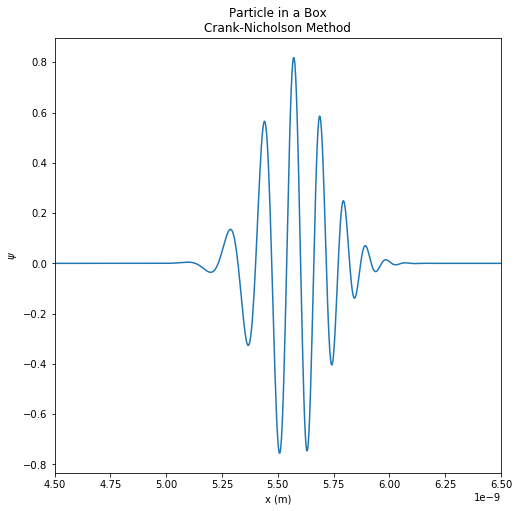

In [3]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded


m = 9.109e-31 # Mass Electron (kg)
L = 1e-8 # Box Length (m)
h_bar = 6.62607004e-34/(2*np.pi) # Planck's Constant (m^2 kg /s)

N = 3000 # Spatial Slices
a = L/N 
x = np.linspace(0, L, N+1)
h = 1e-18 # Timestep (s)
tmax = 1e-14
time = np.arange(0, tmax, h)

# Initial Conditions
x0 = L/2
sigma = 1e-10 # (m)
k = 5e10 # (m^-1)
psi = np.exp(-(x - x0)**2/(2*sigma**2))*np.exp(1j*k*x)

#Boundary Conditions
psi[0] = 0
psi[-1] = 0 

# Tridiagonal Matrices
A1 = 1 + h*1j*h_bar/(2*m*a**2)
A2 = -h*1j*h_bar/(4*m*a**2)
A = np.zeros((3, N-1)) + 0j
A[0] = A2
A[1] = A1
A[2] = A2

B1 = 1 - h*1j*h_bar/(2*m*a**2)
B2 = h*1j*h_bar/(4*m*a**2)

wavefunction = []
for i, t in enumerate(time):
    wavefunction.append(psi.copy())
    v = B1*psi[1:N] + B2*(psi[0:N-1] + psi[2:N+1])
    psi[1:N] = solve_banded((1,1), A, v)
    
snapshot = np.real(wavefunction[int(1e-16/h)])
fig = plt.figure(figsize = (8,8))
plt.plot(x,snapshot)
plt.xlabel("x (m)")
plt.ylabel("$\psi$")
plt.title("Particle in a Box\nCrank-Nicholson Method")
plt.axis(xmin = 0.45e-8,xmax = 0.65e-8)
plt.show()

Make an animation of the solution by displaying the wavefunction from $t=0$ to $t=10^{-14}$ s.

In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate(frame):
    ax.clear()
    snapshot = np.real(wavefunction[int(frame*movie_step/h)])
    plt.plot(x,snapshot)
    plt.xlabel("x")
    plt.ylabel("$\psi$")
    plt.title("Particle in a Box\nCrank-Nicholson Method")
    plt.axis(xmin = 0,xmax = L,ymin = -0.8,ymax = 0.8)
    
numframe = 500
movie_step = tmax/numframe

fig,ax = plt.subplots(figsize = (8,8))

anim = FuncAnimation(fig, animate, frames = numframe, interval = 60)
HTML(anim.to_html5_video())

# The Schr&ouml;dinger Equation and the Spectral Method

(Adapted from textbook exercise 9.9)

This exercise uses the spectral method to solve the time-dependent Sch&ouml;dinger equation
$$-\frac{\hbar^2}{2M} \frac{\partial^2\psi}{\partial x^2} = \mathrm{i}\hbar \frac{\partial\psi}{\partial t}$$
for the same system as in the previous problem, a single particle in one dimension in a box of length $L$ with impenetrable walls. The wavefunction in such a box necessarily goes to zero on the walls and hence one possible
(unnormalized) solution of the equation is
$$\psi_k(x,t) = \sin \biggl( \frac{\pi k x}{L} \biggr)\,e^{-\mathrm{i} Et/\hbar}\,,$$
where the energy $E$ can be found by substituting into the Schr&ouml;dinger equation, giving
$$E = \frac{\pi^2\hbar^2k^2}{2ML^2}\,.$$
We can write a full solution as a linear combination of individual solutions, which on the grid points $x_n=nL/N$ takes the value
$$\psi(x_n,t) = \frac{1}{N} \sum_{k=1}^{N-1} b_k \sin \biggl( \frac{\pi k n}{N} \biggr)\, \exp \biggl( -\mathrm{i}\frac{Et}{\hbar}\biggr)\,,$$
where the $b_k$ are some set of (possibly complex) coefficients that specify the exact shape of the wavefunction and the leading factor of $1/N$ is optional but convenient.

Since the Schr&ouml;dinger equation is first order in time, we need only a single initial condition on the value
of $\psi(x,t)$ to specify the coefficients $b_k$, although, since the coefficients are in general complex, we will need to calculate both real and imaginary parts of each coefficient.

We consider an electron (mass $M=9.109\times10^{-31}$ kg) in a box of length $L=10^{-8}$ m. At time $t=0$ the wavefunction of the electron has the form
$$\psi(x,0) = \exp \biggl[ -\frac{(x-x_0)^2}{2\sigma^2} \biggr]\, e^{\mathrm{i}\kappa x}\,,$$
where
$$x_0 = \frac{L}{2},\qquad \sigma = 1\times10^{-10}\ \mathrm{m},\qquad \kappa = 5\times10^{10}\ \mathrm{m}^{-1}\,,$$
and $\psi=0$ on the walls at $x=0$ and $x=L$.

- Write a program to calculate the values of the coefficients $b_k$, which for convenience can be broken down into their real and imaginary parts as $b_k=\alpha_k+\mathrm{i}\eta_k$. Evaluate $\psi(x,0)$ on $N=1001$ grid points, and perform discrete sine transforms on the real and imaginary part separately, and hence calculate the values of the $\alpha_k$ and $\eta_k$. To perform the discrete sine transforms, you can use the function `dst` from `scipy.fft` (remember to set `norm=ortho`).
  
- Putting $b_k=\alpha_k+\mathrm{i}\eta_k$ in the solution above and taking the real part we get
$$\mathrm{Re}\, \psi(x_n,t) = \frac{1}{N} \sum_{k=1}^{N-1} \biggl[ \alpha_k \cos \biggl( \frac{Et}{\hbar} \biggr) + \eta_k \sin \biggl( \frac{Et}{\hbar} \biggr) \biggr]\, \sin \biggl(\frac{\pi k n}{N} \biggr)$$
for the real part of the wavefunction. This is an inverse sine transform with coefficients equal to the quantities in the square brackets. Extend your program to calculate the real part of the wavefunction $\psi(x,t)$ at an arbitrary time $t$ using this formula and the inverse discrete sine transform function `idst`, also from `scipy.fft` (again set `norm=ortho`).

Test your program by making a graph of the wavefunction at time $t=10^{-16}$ s. It should look nearly identical to your graph in the previous problem.

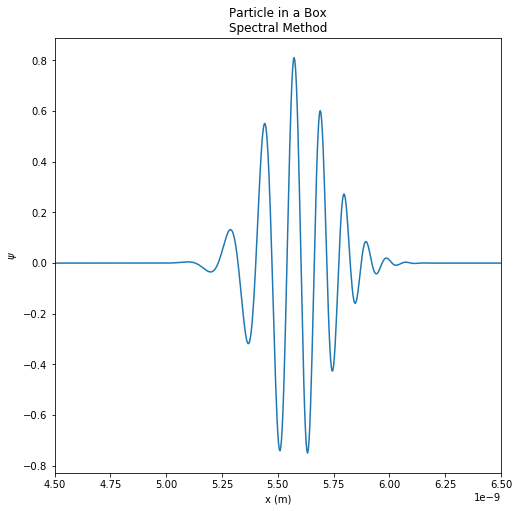

In [5]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dst, idst

m = 9.109e-31 # Mass Electron (kg)
L = 1e-8 # Box Length (m)
h_bar = 6.62607004e-34/(2*np.pi) # Planck's Constant (m^2 kg /s)

N = 3000 # Spatial Slices
h = 1e-18 # Timestep (s)
tmax = 1e-14
time = np.arange(0, tmax, h)

x = np.linspace(0, L, N+1)
k = np.arange(1, N+2)
E = np.pi**2*h_bar**2*k**2/(2*m*L**2)

# Initial Conditions
x0 = L/2
sigma = 1e-10 # (m)
kappa = 5e10 # (m^-1)
psi = np.exp(-(x - x0)**2/(2*sigma**2))*np.exp(1j*kappa*x)

#Boundary Conditions
psi[0] = 0
psi[-1] = 0 

h = 1e-18 # Timestep (s)
tmax = 1e-14
time = np.arange(0, tmax, h)

# Calculate Alpha and Eta
alpha = dst(np.real(psi), norm="ortho")
eta = dst(np.imag(psi), norm="ortho")

wavefunction = []

for t in time:
    psi_dst = alpha*np.cos(E*t/h_bar) + eta*np.sin(E*t/h_bar)
    wavefunction.append(idst(psi_dst, norm="ortho"))

snapshot = np.real(wavefunction[int(1e-16/h)])
plt.close('all')
fig = plt.figure(figsize = (8,8))
plt.plot(x,snapshot)
plt.xlabel("x (m)")
plt.ylabel("$\psi$")
plt.title("Particle in a Box\nSpectral Method")
plt.axis(xmin = 0.45e-8,xmax = 0.65e-8)
plt.show()

Make an animation of the solution by displaying the wavefunction from $t=0$ to $t=10^{-14}$ s. It should look nearly identical to your animation in the previous problem.

In [6]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate(frame):
    ax.clear()
    snapshot = np.real(wavefunction[int(frame*movie_step/h)])
    plt.plot(x,snapshot)
    plt.xlabel("x")
    plt.ylabel("$\psi$")
    plt.title("Particle in a Box\nSpectral Method")
    plt.axis(xmin = 0,xmax = L,ymin = -0.8,ymax = 0.8)
    
numframe = 500
movie_step = tmax/numframe

fig,ax = plt.subplots(figsize = (8,8))

anim = FuncAnimation(fig, animate, frames = numframe, interval = 60)
HTML(anim.to_html5_video())